In [2]:
!pip install peft
!pip install datasets

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import os
# os.listdir('/content/drive/My Drive/')

In [5]:
drivePath = "/kaggle/working/"
datasetPath = "/kaggle/input/ecpe-dataset/Subtask_1_train.json"

In [6]:
import json

with open(datasetPath) as f:
    data = json.load(f)

<hr>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peft

warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
from peft import LoraConfig, TaskType, get_peft_model, PeftModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

In [8]:
pretrained_model = "tae898/emoberta-large"

model_l0 = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

for param in model_l0.parameters():
    param.requires_grad = False

for param in model_l0.roberta.encoder.layer[-1].parameters():
    param.requires_grad = True

for param in model_l0.classifier.parameters():
    param.requires_grad = True

tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/408 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

<hr>

In [9]:
model_l0.config

RobertaConfig {
  "_name_or_path": "tae898/emoberta-large",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "neutral",
    "1": "joy",
    "2": "surprise",
    "3": "anger",
    "4": "sadness",
    "5": "disgust",
    "6": "fear"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "anger": 3,
    "disgust": 5,
    "fear": 6,
    "joy": 1,
    "neutral": 0,
    "sadness": 4,
    "surprise": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.39.3",
  "type_vocab_size":

In [10]:
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

class CustomDataset(Dataset):
    def __init__(self, json_data, label2id):
        self.data = json_data
        self.emotions_map = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        data = deepcopy(self.data[idx])

        conversationID = data['conversation_ID']
        conversation = data['conversation']
        cause_pairs = data['emotion-cause_pairs']

        conversationID -= 1

        for utt in conversation:
            utt["utterance_ID"] -= 1

        conversation = sorted(conversation, key=lambda x: x["utterance_ID"])

        def extract(x, y):
            idx, emotion = x.split("_", maxsplit=1)
            idc, subtext = y.split("_", maxsplit=1)

            idx = int(idx) - 1
            idc = int(idc) - 1

            return {
                "cause_pair": (idx, idc),
                "cause_emotion": emotion,
                "cause_subtext": subtext,
            }

        alcause_pairs = [extract(x, y) for x, y in cause_pairs]
        conversations = []

        for x in conversation:
            row = {
                "conversation_ID": conversationID,
                "label_": self.emotions_map[x["emotion"]],
                **x,
                "cause": [c for c in alcause_pairs if c["cause_pair"][0] == x["utterance_ID"]]
            }

            conversations.append(row)

        return conversations

dataset = CustomDataset(data, model_l0.config.label2id)

In [11]:
def collate_fn(batch):

    all_texts = []
    all_speakers = []
    all_attn_target = []
    all_labels = []

    for samples in batch:
        texts = list(map(lambda x: x["text"], samples))
        causes = list(map(lambda x: x["cause"], samples))
        labels_ = list(map(lambda x: x["label_"], samples))
        speakers = list(map(lambda x: x["speaker"], samples))

        attn_target = torch.zeros(len(samples), len(samples))

        causes = sum(causes, [])
        causes = list(map(lambda x: x["cause_pair"], causes))
        causes = torch.tensor(causes)
        labels = torch.tensor(labels_)

        if len(causes) > 0:
            attn_target[causes[:, 0], causes[:, 1]] = 1

        all_texts.append(texts)
        all_speakers.append(speakers)
        all_attn_target.append(attn_target)
        all_labels.append(labels)

    return {"all_texts": all_texts,
            "all_speaker": all_speakers,
            "all_attn_target": all_attn_target, "all_labels": all_labels}

In [12]:
from torch.utils.data import random_split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

batch_size = 8
data_loaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn,num_workers=4, pin_memory=True),
    "test": DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=4, pin_memory=True)
}

<hr>

In [13]:
labels = torch.tensor(
    [row["label_"] for rows in dataset for row in rows])

counts = torch.unique(labels, return_counts=True)[1]

cls_weight = counts.sum() / counts
cls_weight = (cls_weight / cls_weight.sum()).to(device)

In [14]:
cls_weight

tensor([0.0218, 0.0562, 0.0703, 0.0801, 0.1127, 0.3123, 0.3466],
       device='cuda:0')

<hr>

In [15]:
import os
emobertPath = drivePath + '/emobert/'
emobertPathModels = emobertPath + "models/"
if not os.path.exists(emobertPathModels):
    os.makedirs(emobertPathModels)

In [16]:
def train_emotion_classifier(model, tokenizer, data_loaders, num_epochs):
    total_reports = []

    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_l0.parameters()), lr=1e-6)

    model.to(device)

    for epoch in range(num_epochs):

        for phase in ["train", "test"]:

            if phase == "train":
                model.train()
            else:
                model.eval()

            reports = []

            for batch in tqdm(data_loaders[phase]):

                all_texts = sum(batch["all_texts"], [])
                all_speaker = sum(batch["all_speaker"], [])

                all_labels = torch.concatenate(batch["all_labels"])
                all_labels = all_labels.to(device)
                all_labels = all_labels.long()

                texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]

                inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
                inputs = inputs.to(device)

                input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

                output = model(input_ids=input_ids, attention_mask=attention_mask)

                loss = F.cross_entropy(output.logits, all_labels, weight=cls_weight)

                pred = output.logits.max(dim=1)[1]

                accuracy = (all_labels == pred).sum() / all_labels.size(0)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                report = {"phase": phase, "loss": loss.item(), "accuracy": accuracy.item()}

                reports.append(report)

            dc = pd.DataFrame(reports)
            dc = dc.describe()
            dc = dc.round(3)
            total_reports.extend(reports)

            print(F"{epoch}. using {phase}:", dc.loc["mean"].to_json())

    return model, total_reports

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def train_emotion_classifier(model, tokenizer, data_loaders, num_epochs):
    total_reports = []

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    scaler = GradScaler()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
                torch.set_grad_enabled(False)

            reports = []

            for batch in tqdm(data_loaders[phase]):
                all_texts = sum(batch["all_texts"], [])
                all_speaker = sum(batch["all_speaker"], [])
                all_labels = torch.cat(batch["all_labels"]).to(device).long()

                texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]
                inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True).to(device)

                with autocast(enabled=True):
                    outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                    loss = nn.CrossEntropyLoss()(outputs.logits, all_labels)

                pred = outputs.logits.argmax(dim=1)
                labels = all_labels.cpu().numpy()
                preds = pred.cpu().numpy()

                accuracy = accuracy_score(labels, preds)
                precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
                #auc_roc = roc_auc_score(labels, torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy())

                if phase == "train":
                    scaler.scale(loss).backward()
                    clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    scheduler.step()

                report = {
                    "phase": phase,
                    "loss": loss.item(),
                    "accuracy": accuracy,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1
                }
                reports.append(report)

            if phase == 'test':
                torch.set_grad_enabled(True)

            dc = pd.DataFrame(reports)
            epoch_summary = dc.describe().loc["mean"]
            total_reports.extend(reports)
            print(f"{epoch} - {phase} Summary:", epoch_summary.to_dict())

    return model, total_reports


In [18]:
model, total_reports = train_emotion_classifier(model_l0, tokenizer, data_loaders, num_epochs=5)

  0%|          | 0/155 [00:00<?, ?it/s]

0 - train Summary: {'loss': 1.0178004403268137, 'accuracy': 0.6647318074947742, 'precision': 0.5052854114966955, 'recall': 0.4833050312159234, 'f1': 0.47029165813953044}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/18 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0 - test Summary: {'loss': 1.0378875897990332, 'accuracy': 0.6715057342863772, 'precision': 0.5649502628720753, 'recall': 0.5513609641462133, 'f1': 0.5260921428561358}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/155 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

1 - train Summary: {'loss': 1.0107563487945064, 'accuracy': 0.6613866564019045, 'precision': 0.5258373787694057, 'recall': 0.5065149993845713, 'f1': 0.49228113773748444}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/18 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

1 - test Summary: {'loss': 1.0378875897990332, 'accuracy': 0.6715057342863772, 'precision': 0.5649502628720753, 'recall': 0.5513609641462133, 'f1': 0.5260921428561358}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/155 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2 - train Summary: {'loss': 1.0153031987528647, 'accuracy': 0.6634634037261591, 'precision': 0.51176875141002, 'recall': 0.4920485799625983, 'f1': 0.4776992696246513}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/18 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2 - test Summary: {'loss': 1.0378875897990332, 'accuracy': 0.6715057342863772, 'precision': 0.5649502628720753, 'recall': 0.5513609641462133, 'f1': 0.5260921428561358}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/155 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

3 - train Summary: {'loss': 1.0147963554628434, 'accuracy': 0.6633189687773121, 'precision': 0.5167086821102476, 'recall': 0.4915530857438009, 'f1': 0.4783901990086305}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/18 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

3 - test Summary: {'loss': 1.0378875897990332, 'accuracy': 0.6715057342863772, 'precision': 0.5649502628720753, 'recall': 0.5513609641462133, 'f1': 0.5260921428561358}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/155 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

4 - train Summary: {'loss': 1.004678406638484, 'accuracy': 0.6686033767040314, 'precision': 0.5093651026114672, 'recall': 0.4950999944904472, 'f1': 0.48109267361805613}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/18 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

4 - test Summary: {'loss': 1.0378875897990332, 'accuracy': 0.6715057342863772, 'precision': 0.5649502628720753, 'recall': 0.5513609641462133, 'f1': 0.5260921428561358}


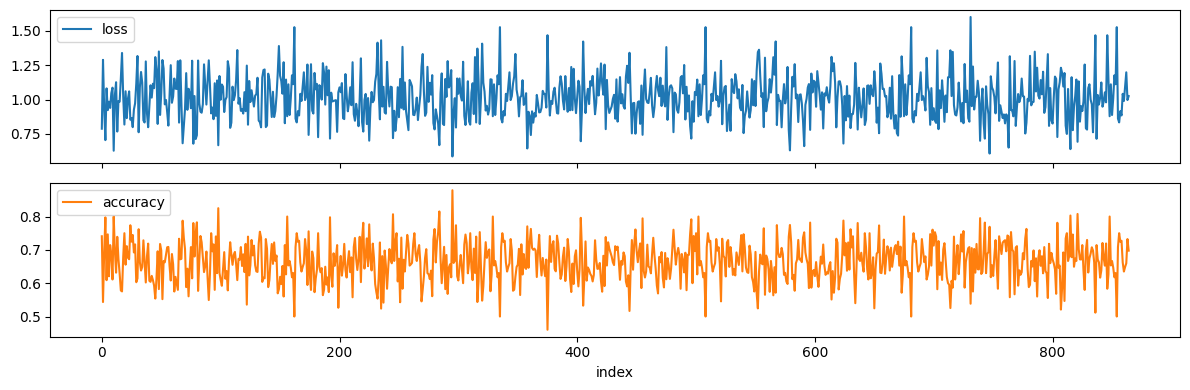

In [19]:
df = pd.DataFrame(total_reports).reset_index()
df["index"] = df["index"]

df = df.groupby("index")\
    .agg(loss=("loss", "mean"), accuracy=("accuracy", "mean"))

df.plot(subplots=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

In [20]:
with open(emobertPathModels + 'model_l0_v07.pth', 'wb') as f:
    torch.save(model.state_dict(), f)

<hr>

In [21]:
model_l0 = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")
_ = model_l0.load_state_dict(torch.load(emobertPathModels + "model_l0_v07.pth", map_location="cpu"))
_ = model_l0.eval()

In [22]:
import torch
import torch.nn as nn

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.normalizer = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.normalizer(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x, weights = self.self_attn(x, x, x, attn_mask=mask)
        return x, weights

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, logit_dim, model_dim, n_layers, n_heads, ff_dim, max_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.compressor = nn.Linear(embed_dim + logit_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = self.get_positional_encoding(max_len, model_dim).permute(1, 0, 2)
        self.layers = nn.ModuleList([EncoderLayer(model_dim, n_heads, ff_dim, dropout) for _ in range(n_layers)])


    def get_positional_encoding(self, max_len, d_model):
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(np.log(10000.0) / d_model))
        pos_enc = torch.zeros((max_len, 1, d_model))
        pos_enc[:, 0, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 0, 1::2] = torch.cos(position * div_term)
        return pos_enc

    def forward(self, x, y, mask=None):

        x = torch.concatenate((x, y), dim=-1)
        x = self.compressor(x)
        x = self.dropout(x)

        x = x + self.positional_encoding[:, :x.shape[1], :].to(x.device)

        for layer in self.layers:
            x, weights = layer(x, mask)

        return x, weights

model_l1 = TransformerEncoder(embed_dim=1024, model_dim=256, logit_dim=7, n_layers=1, n_heads=1, ff_dim=1024, max_len=40)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_l1)

1053440

In [24]:
# from torch.optim.lr_scheduler import StepLR

# def train_cause_pair_extraction(embed_model, model, tokenizer, data_loaders, num_epochs=5):
#     total_reports = []

#     optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
#     model.to(device)
#     embed_model.eval()
#     embed_model.to(device)

#     for epoch in range(num_epochs):

#         for phase in ["train", "test"]:

#             if phase == "train":
#                 model.train()
#             else:
#                 model.eval()

#             reports = []

#             for batch in tqdm(data_loaders[phase]):

#                 total_loss = 0.

#                 for all_texts, all_speaker, attn_targets, _ in zip(*batch.values()):

#                     attn_targets = attn_targets.to(device)

#                     texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]
#                     if(epoch==0):
#                       print(f"Printing texts:{texts[0]}")

#                     inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
#                     inputs = inputs.to(device)
#                     print(inputs)
#                     input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

#                     with torch.no_grad():
#                         output = embed_model(
#                             input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

#                         embeds = output.hidden_states[-1][:, 0, :]
#                         logits = F.softmax(output.logits, dim=-1)

#                     embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)


#                     # print(f"Embeds SHape:{embeds.shape}")
#                     # print(f"Logits Shape:{logits.shape}")
#                     # print(f"Model: \n{model}\n")
#                     # outputs_temp = model(embeds,logits)
#                     # print(f"Outputs: {outputs_temp} \n")
#                     # print(f"Type of outputs {type(outputs)}")
#                     # print(f"Output Length: {len(outputs)}")

#                     # if isinstance(outputs, (list, tuple)) and len(outputs) > 1:
#                     #   weights = outputs[1].squeeze(0)
#                     # else:
#                     #     raise ValueError("Model output does not contain enough elements to index [1]")


#                     weights = model(embeds, logits)[1].squeeze(0)

#                     loss = F.mse_loss(weights * 10, attn_targets * 10)

#                     total_loss += loss

#                     delta = torch.abs(attn_targets - weights)
#                     recall = ((delta < 0.5) * (attn_targets == 1)).sum() / (attn_targets == 1).sum()
#                     accuracy = (delta < 0.5).sum() / delta.numel()

#                     report = {"phase": phase, "loss": loss.item(), "accuracy": accuracy.item(), "recall": recall.item()}

#                     reports.append(report)

#                 if phase == "train":
#                     optimizer.zero_grad()
#                     total_loss.backward()
#                     optimizer.step()

#             dc = pd.DataFrame(reports)
#             dc = dc.describe()
#             dc = dc.round(3)

#             total_reports.extend(reports)

#             print(F"{epoch}.{phase}:", dc.loc["mean"].to_json())

#     return model, total_reports

In [25]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import pandas as pd

def train_cause_pair_extraction(embed_model, model, tokenizer, data_loaders, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_reports = []
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    model.to(device)
    embed_model.eval()
    embed_model.to(device)

    for epoch in range(num_epochs):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            reports = []
            for batch in tqdm(data_loaders[phase]):
                total_loss = torch.tensor(0., device=device)  # Initialize as a tensor


                for all_texts, all_speaker, attn_targets, _ in zip(*batch.values()):
                    attn_targets = attn_targets.to(device)
                    texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]

                    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
                    inputs = inputs.to(device)
                    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

                    with torch.no_grad():
                        output = model(input_ids=input_ids, attention_mask=attention_mask,output_hidden_states=True)
                        embeds = output.hidden_states[-1][:, 0, :]
                        logits = F.softmax(output.logits, dim=-1)  # Directly accessing logits

                    embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)  # Ensuring tensors are properly shaped

                    outputs = embed_model(embeds, logits)  # Assuming embed_model is correctly expecting these tensors
                    weights = outputs[1].squeeze(0) if len(outputs) > 1 else None  # Safely handling model outputs

                    if weights is None:
                        raise ValueError("Model output does not contain enough elements to index [1]")

                    loss = F.mse_loss(weights * 10, attn_targets * 10)
                    total_loss += loss

                    delta = torch.abs(attn_targets - weights)
                    recall = ((delta < 0.5) * (attn_targets == 1)).sum() / (attn_targets == 1).sum()
                    accuracy = (delta < 0.5).sum() / delta.numel()

                    is_within_threshold = delta < 0.5

                    # Compute true positives, false positives, and false negatives
                    true_positives = ((is_within_threshold) & (attn_targets == 1)).sum().item()
                    false_positives = ((is_within_threshold) & (attn_targets == 0)).sum().item()
                    false_negatives = ((~is_within_threshold) & (attn_targets == 1)).sum().item()

                    # Calculate precision, recall, and F1 score
                    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
                    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
                    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


                    report = {"phase": phase, "loss": loss.item(), "accuracy": accuracy.item(), "recall": recall,"f1_score": f1_score,"precision":precision}
                    reports.append(report)

                if phase == "train":
                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()

            dc = pd.DataFrame(reports)
            dc = dc.describe()
            dc = dc.round(3)
            total_reports.extend(reports)

            print(f"{epoch}.{phase}:", dc.loc["mean"].to_json())

    return model, total_reports


In [26]:
model, total_reports = train_cause_pair_extraction(model_l1, model, tokenizer, data_loaders, num_epochs=8)

  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

0.train: {"loss":10.309,"accuracy":0.881,"recall":0.025,"f1_score":0.02,"precision":0.018}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

0.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

1.train: {"loss":10.31,"accuracy":0.88,"recall":0.024,"f1_score":0.019,"precision":0.018}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

1.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

2.train: {"loss":10.309,"accuracy":0.881,"recall":0.025,"f1_score":0.02,"precision":0.018}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

2.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

3.train: {"loss":10.309,"accuracy":0.881,"recall":0.025,"f1_score":0.02,"precision":0.018}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

3.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

4.train: {"loss":10.309,"accuracy":0.882,"recall":0.028,"f1_score":0.021,"precision":0.019}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

4.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

5.train: {"loss":10.308,"accuracy":0.881,"recall":0.026,"f1_score":0.02,"precision":0.019}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

5.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

6.train: {"loss":10.307,"accuracy":0.881,"recall":0.025,"f1_score":0.02,"precision":0.018}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

6.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


  0%|          | 0/155 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(tru

7.train: {"loss":10.308,"accuracy":0.882,"recall":0.027,"f1_score":0.021,"precision":0.019}


  0%|          | 0/18 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

7.test: {"loss":8.246,"accuracy":0.912,"recall":0.029,"f1_score":0.023,"precision":0.021}


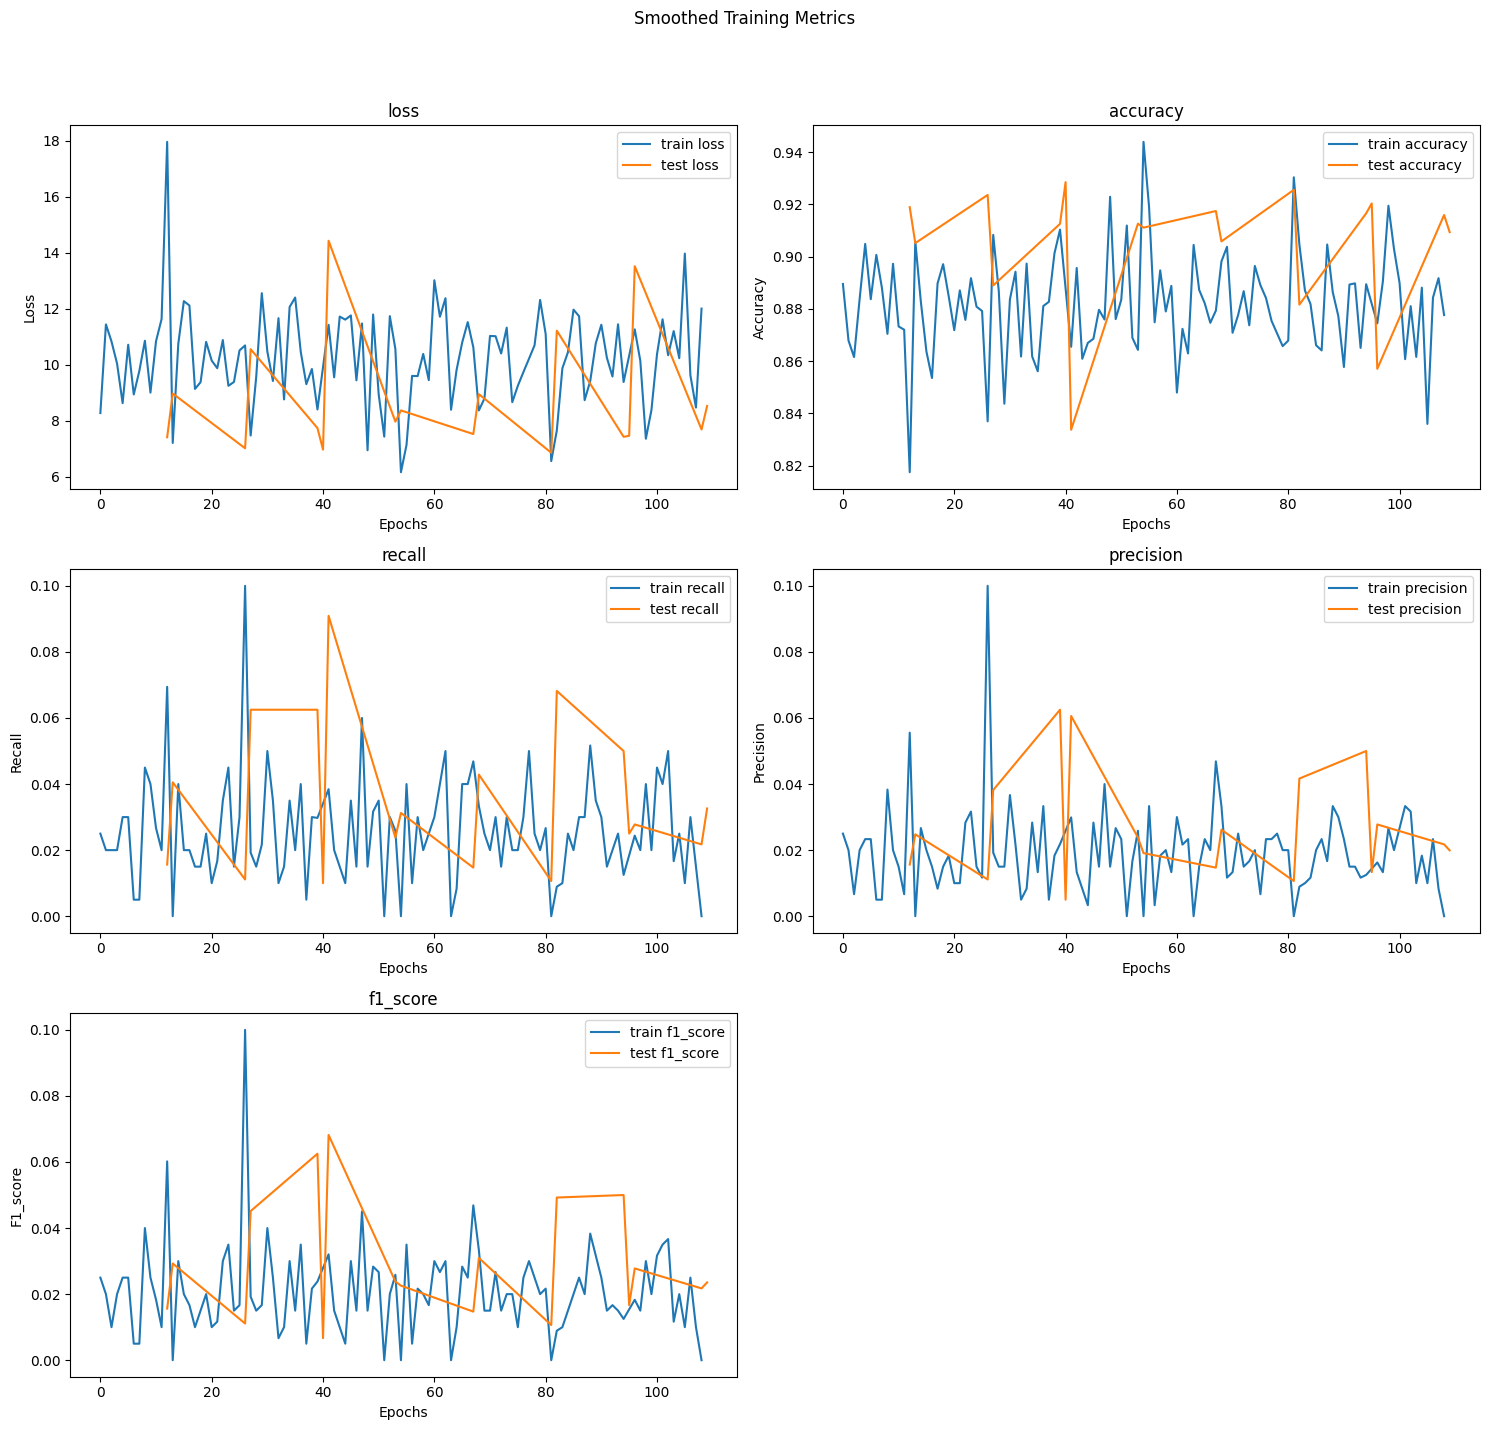

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_smoothed_metrics(total_reports):
    # Convert list of reports into a DataFrame
    df = pd.DataFrame(total_reports)
    
    # Assuming 'epoch' is provided in the reports or calculate based on an index or batch size
    # Here, let's add an 'epoch' column if not already present
    if 'epoch' not in df.columns:
        df['epoch'] = df.index // 100  # Adjust this based on how many batches per epoch
    
    # Create plots for each metric
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Smoothed Training Metrics')
    
    # Define the metrics you want to plot
    metrics = ['loss', 'accuracy', 'recall', 'precision', 'f1_score']
    
    # Plotting each metric
    for i, metric in enumerate(metrics):
        ax = axes.flat[i]
        for phase in ['train', 'test']:
            subset = df[df['phase'] == phase]
            
            # Group by epoch and calculate mean for smoother curves
            epoch_data = subset.groupby('epoch')[metric].mean()
            
            ax.plot(epoch_data, label=f'{phase} {metric}')
            ax.set_title(metric)
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.capitalize())
            ax.legend()
        
        # Hide the last empty subplot if metrics are an odd number
        if len(metrics) % 2 != 0 and i == len(metrics) - 1:
            ax = axes.flat[i + 1]
            ax.set_visible(False)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_smoothed_metrics(total_reports)

In [28]:
df.columns

Index(['loss', 'accuracy'], dtype='object')

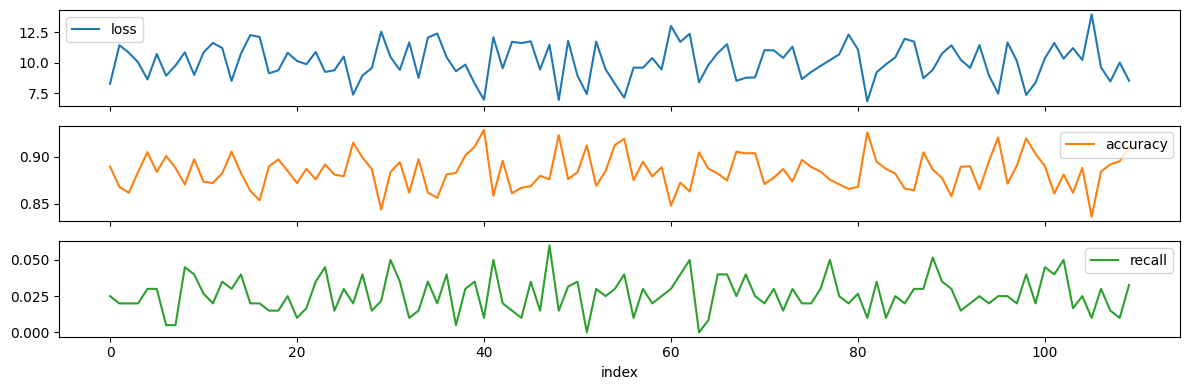

In [29]:
df = pd.DataFrame(total_reports).reset_index()
df["index"] = df["index"] // 100

df = df.groupby("index")\
    .agg(loss=("loss", "mean"), accuracy=("accuracy", "mean"), recall=("recall", "mean"))

df.plot(subplots=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

In [30]:
custom_model = model

In [31]:
custom_model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [32]:
with open(emobertPathModels + 'model_l1_v09.pth', 'wb') as f:
    torch.save(custom_model.state_dict(), f)

<hr>

In [33]:
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-large")
model_l0 = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")

model_l0.load_state_dict(torch.load(emobertPathModels +  "model_l0_v07.pth", map_location="cpu"))
model_l0.eval()

custom_model.load_state_dict(torch.load(emobertPathModels + "model_l1_v09.pth", map_location="cpu"))
custom_model.eval()

test_dataset = iter(data_loaders["test"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [34]:
@torch.no_grad
def generate_causality_matrix(model_l0, model_l1, tokenizer, all_texts, all_speaker):

    model_l0.to("cpu")
    model_l1.to("cpu")

    texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']

    with torch.no_grad():
        output = model_l0(
            input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

        embeds = output.hidden_states[-1][:, 0, :]
        logits = F.softmax(output.logits, dim=-1)

    embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)

    weights = model_l1(embeds, logits)[1].squeeze(0)

    return torch.round(weights, decimals=2)

In [35]:
sample = next(test_dataset)

all_texts = sample["all_texts"][0]
all_speaker = sample["all_speaker"][0]

causalattn = generate_causality_matrix(model_l0, model_l1, tokenizer, all_texts, all_speaker)

print("predicted: " , (causalattn > 0.5).long(), sep="\n")
print("delta: ", sample["all_attn_target"][0].long(), sep="\n")

predicted: 
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
delta: 
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],

<hr>

In [36]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

model_name = "deepset/deberta-v3-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/735M [00:00<?, ?B/s]

In [37]:
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)

qa_model = get_peft_model(qa_model, peft_config)

qa_model.print_trainable_parameters()

trainable params: 296,450 || all params: 184,129,540 || trainable%: 0.1610


In [38]:
def qa_preparation(examples):

    samples = []
    prompt = "Which part of the text ’{}’ is the reason for ’ {} ’'s feeling of ’ {} ’ when ’ {} ’ is said?"

    for exp in examples:
        for ut in exp:
            for c in ut["cause"]:

                src = c["cause_pair"][0]
                tgt = c["cause_pair"][1]

                x = {
                    "question": prompt.format(exp[tgt]["text"], ut["speaker"], c["cause_emotion"], exp[src]["text"]),
                    "context": exp[tgt]["text"],
                    'answers': {
                        'text': [c["cause_subtext"]],
                        'answer_start': [exp[tgt]["text"].find(c["cause_subtext"])]
                    }
                }
                samples.append(x)

    return samples

In [39]:
train_dataset_qa = qa_preparation(train_dataset)
valid_dataset_qa = qa_preparation(valid_dataset)

In [40]:
from datasets import Dataset, DatasetDict

dataset_qa = DatasetDict({
    "train": Dataset.from_list(train_dataset_qa[:]),
    "test": Dataset.from_list(valid_dataset_qa[:]),
})

In [41]:
dataset_qa

DatasetDict({
    train: Dataset({
        features: ['question', 'context', 'answers'],
        num_rows: 8405
    })
    test: Dataset({
        features: ['question', 'context', 'answers'],
        num_rows: 959
    })
})

In [42]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]

    inputs = tokenizer(questions, examples["context"], return_offsets_mapping=True, padding="max_length", truncation=True)

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"], inputs["end_positions"] = start_positions, end_positions

    return inputs

tokenized_qa = dataset_qa.map(preprocess_function, batched=True, remove_columns=dataset_qa["train"].column_names)

Map:   0%|          | 0/8405 [00:00<?, ? examples/s]

Map:   0%|          | 0/959 [00:00<?, ? examples/s]

In [44]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [45]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=emobertPathModels + "qa",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision
)

trainer = Trainer(
    model=qa_model, args=training_args,
    train_dataset=tokenized_qa["train"], eval_dataset=tokenized_qa["test"],
    tokenizer=tokenizer, data_collator=data_collator,
)

In [58]:
from transformers import TrainingArguments, Trainer
import torch
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=2e-5)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Assuming logits are the first element if they are in a tuple
    if isinstance(logits, tuple):
        logits = logits[0]
    predictions = np.argmax(logits, axis=-1)

    # Basic handling if labels are in a different format
    if isinstance(labels, tuple):
        labels = labels[0]
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()  # Convert to numpy array if still in tensor format

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



num_epochs = 5
per_device_train_batch_cut = 8
num_replicas = 1
# Learning Rate Scheduler
num_training_steps = num_epochs * len(train_dataset) // (per_device_train_batch_cut * num_replicas)
lr_scheduler = get_scheduler(
    name="linear",  # Using a linear schedule
    optimizer=optimizer,
    num_warmup_steps=0,  # You can set a num_warmup_steps if needed
    num_training_steps=num_training_steps
)

training_args = TrainingArguments(
    output_dir=emobertPathModels + "qa",
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=4,  # Use gradient accumulation
    do_train=True,
    do_eval=True,
    logging_dir="./logs",  # Directory for storing logs
    report_to="all",  # Enable reporting for all integrations
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy",  # Use accuracy to save the best model
    greater_is_better=True,
    dataloader_num_workers=4,  # Use multiple workers to load data
    dataloader_pin_memory=True,  # Enable pinning memory
    gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
    disable_tqdm=False,  # Keep tqdm progress bars
    optim="adamw_torch",  # Use PyTorch's native AdamW
    save_strategy="epoch",  # Save at the end of each epoch to match evaluation strategy
    save_steps=None  # Disable saving based on number of steps
)

# Set up the Trainer
trainer = Trainer(
    model=qa_model,
    args=training_args,
    train_dataset=tokenized_qa["train"],
    eval_dataset=tokenized_qa["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# Turn on cudNN benchmarking
torch.backends.cudnn.benchmark = True

In [59]:
torch.cuda.empty_cache()

In [60]:
!nvidia-smi


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri May 17 23:28:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              29W /  70W |   2489MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [61]:
!pip install tensorboard

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C
ERROR: Operation cancelled by user


In [62]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard within the notebook using Jupyter's magic command
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
 %reload_ext tensorboard

In [64]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,2.606683,0.233577,0.141364,0.155750,0.149905
2,No log,2.269354,0.276330,0.163035,0.172670,0.175953
4,2.413100,2.079598,0.300313,0.189109,0.197718,0.200430
6,2.413100,1.967948,0.322211,0.189880,0.198687,0.201303
8,1.864000,1.900631,0.338895,0.204826,0.215479,0.213689
10,1.864000,1.851097,0.351408,0.214260,0.224634,0.222155
12,1.636200,1.818708,0.358707,0.221486,0.231633,0.229807
14,1.636200,1.795761,0.371220,0.227003,0.236590,0.236392
16,1.540500,1.780814,0.375391,0.230339,0.240690,0.239231
18,1.540500,1.773829,0.377477,0.231249,0.241661,0.239989


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=2620, training_loss=1.7770517189084118, metrics={'train_runtime': 6879.3238, 'train_samples_per_second': 24.436, 'train_steps_per_second': 0.381, 'total_flos': 4.391293427651789e+16, 'train_loss': 1.7770517189084118, 'epoch': 19.92})

In [66]:
# Evaluate the model on the validation (test) dataset
eval_results = trainer.evaluate()

print("Evaluation Results:", eval_results)

# Get predictions on the validation (test) dataset
predictions = trainer.predict(tokenized_qa["test"])

# print("Predictions:", predictions.predictions)
# print("Labels:", predictions.label_ids)
print("Metrics:", predictions.metrics)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluation Results: {'eval_loss': 1.7738287448883057, 'eval_accuracy': 0.37747653806047965, 'eval_f1': 0.2312492366271948, 'eval_precision': 0.2416614547635315, 'eval_recall': 0.23998923665788632, 'eval_runtime': 27.1892, 'eval_samples_per_second': 35.271, 'eval_steps_per_second': 2.207, 'epoch': 19.92}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Metrics: {'test_loss': 1.7738287448883057, 'test_accuracy': 0.37747653806047965, 'test_f1': 0.2312492366271948, 'test_precision': 0.2416614547635315, 'test_recall': 0.23998923665788632, 'test_runtime': 27.8093, 'test_samples_per_second': 34.485, 'test_steps_per_second': 2.158}


In [69]:
import numpy as np
import pandas as pd

from torch.utils.data import DataLoader

# Assuming dataset_qa['test'] is already a PyTorch Dataset object
dataloader = DataLoader(dataset_qa['test'], batch_size=32, shuffle=False)


# Function to identify failed examples
def identify_failed_examples(predictions, labels, examples):
    failed_examples = []
    for i, (pred, label) in enumerate(zip(predictions, labels)):
        if not np.array_equal(pred, label):
            failed_examples.append({
                "index": i,
                "predicted": pred,
                "actual": label,
                "context": examples[i]["context"],
                "question": examples[i]["question"],
                "answer": examples[i]["answers"]["text"][0]
            })
    return failed_examples

# Extract logits from predictions tuple
logits = predictions.predictions[0] if isinstance(predictions.predictions, tuple) else predictions.predictions

# Get the predicted and actual labels
pred_labels = logits.argmax(axis=-1)
actual_labels = predictions.label_ids

# Extract failed examples
failed_examples = identify_failed_examples(pred_labels, actual_labels, tokenized_qa["test"])

# Convert to DataFrame for easy annotation and analysis
failed_df = pd.DataFrame(failed_examples)

# Save to CSV for manual annotation
failed_df.to_csv("failed_examples.csv", index=False)

print(f"Total Failed Examples: {len(failed_df)}")

# Display a sample of failed examples
failed_df.sample(10)


KeyError: 'context'

<hr>

In [79]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

checkpoint = "/kaggle/working/emobert/models/qa/checkpoint-2620"
model_name = "deepset/deberta-v3-base-squad2"

qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
qa_model = PeftModel.from_pretrained(qa_model, checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [80]:
inputs = tokenizer(
    dataset_qa["test"]["question"],
    dataset_qa["test"]["context"],
    padding=True, truncation=True, return_tensors="pt")

In [81]:
inputs["input_ids"].shape

torch.Size([959, 177])

In [82]:
if torch.cuda.is_available():
    device = torch.device("cpu")  # Use the first GPU
    model = qa_model.to(device)  # Move your model to GPU
    print("Model has been moved to GPU.")
else:
    print("CUDA is not available. Model is using CPU.")

Model has been moved to GPU.


In [83]:
# Assuming inputs is a dictionary of tensors
inputs = {k: v.to(device) for k, v in inputs.items()}  # Ensure inputs are on the same device as the model

# Now you can perform inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:

# with torch.no_grad():
#     outputs = qa_model(**inputs)

In [84]:
answer_start_index, answer_end_index = \
    outputs.start_logits.argmax(dim=-1).tolist(), outputs.end_logits.argmax(dim=-1).tolist()

In [156]:
# answers = []

# for i, (start, end) in enumerate(zip(answer_start_index, answer_end_index)):
#     answer = tokenizer.decode(inputs.input_ids[i, start : end + 1])
#     answers.append(answer)

In [85]:
answers = []

for i, (start, end) in enumerate(zip(answer_start_index, answer_end_index)):
    answer = tokenizer.decode(inputs['input_ids'][i, start : end + 1])
    answers.append(answer)

In [86]:
ground_truth = dataset_qa["test"]["answers"]
context = dataset_qa["test"]["context"]

report = [
    {"context": cnx, "prediction": ans, "ground_truth": d2["text"][0]}
    for cnx, ans, d2 in zip(context, answers, ground_truth)
]

In [87]:
print(len(report))

959


In [89]:
# Convert the report object to a JSON string
report_json = json.dumps(report, indent=4)

# Specify the file name
file_name = 'report.json'

# Save the JSON string to a file
with open(file_name, 'w') as file:
    file.write(report_json)

print(f"JSON data has been saved to {file_name}")

JSON data has been saved to report.json


In [103]:
import torch
import json

# Assuming you have a PyTorch model and DataLoader
# model: Your trained PyTorch model
# dataloader: Your DataLoader for the dataset
from torch.utils.data import DataLoader

# Assuming dataset_qa['test'] is already a PyTorch Dataset object
dataloader = DataLoader(dataset_qa['test'], batch_size=32, shuffle=False)


model.eval()

# Function to decode predictions
def decode_predictions(outputs, inputs):
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    predictions = []
    for i in range(len(start_logits)):
        start_index = torch.argmax(start_logits[i])
        end_index = torch.argmax(end_logits[i])
        input_ids = inputs['input_ids'][i]
        prediction = tokenizer.decode(input_ids[start_index:end_index+1])
        predictions.append(prediction)
    return predictions

# Function to get ground truth answers
def decode_labels(labels):
    ground_truths = []
    for label in labels:
        answer_text = label['text'][0]
        ground_truths.append(answer_text)
    return ground_truths

# Function to normalize text
def normalize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Function to compare texts
def compare_texts(prediction, ground_truth):
    prediction = normalize_text(prediction)
    ground_truth = normalize_text(ground_truth)
    
    # Tokenize
    pred_tokens = word_tokenize(prediction)
    gt_tokens = word_tokenize(ground_truth)
    
    # Use SequenceMatcher to get the similarity ratio
    similarity = SequenceMatcher(None, pred_tokens, gt_tokens).ratio()
    
    # Consider it a match if similarity is above a threshold, e.g., 0.8
    return similarity >= 0.8

# List to store misclassified examples
misclassified = []

# Evaluation loop
with torch.no_grad():
    for batch in dataloader:
        print(batch)
        inputs = {
            'input_ids': batch['input_ids'],
            'attention_mask': batch['attention_mask']
        }
        labels = batch['answers']

        outputs = model(**inputs)
        
        predictions = decode_predictions(outputs, inputs)
        ground_truths = decode_labels(labels)
        
        for context, prediction, ground_truth in zip(batch['context'], predictions, ground_truths):
            if not compare_texts(prediction, ground_truth):
                misclassified.append({
                    'context': context,
                    'prediction': prediction,
                    'ground_truth': ground_truth
                })

# Convert the misclassified examples to a JSON string
misclassified_json = json.dumps(misclassified, indent=4)

# Specify the file name
file_name = 'misclassified_report.json'

# Save the JSON string to a file
with open(file_name, 'w') as file:
    file.write(misclassified_json)

print(f"Misclassified examples have been saved to {file_name}")

{'question': ["Which part of the text ’I do not know . We are talking about whipped fish , Monica . I am just happy I am keeping it down , you know ?’ is the reason for ’ Joey ’'s feeling of ’ disgust ’ when ’ I do not know . We are talking about whipped fish , Monica . I am just happy I am keeping it down , you know ? ’ is said?", "Which part of the text ’My God ! What happened to you ?’ is the reason for ’ Rachel ’'s feeling of ’ surprise ’ when ’ My God ! What happened to you ? ’ is said?", "Which part of the text ’Eight and a half hours of aptitude tests , intelligence tests , personality tests ... and what do I learn ?’ is the reason for ’ Chandler ’'s feeling of ’ anger ’ when ’ Eight and a half hours of aptitude tests , intelligence tests , personality tests ... and what do I learn ? ’ is said?", 'Which part of the text ’" You are ideally suited for a career in data processing for a large multinational corporation . "’ is the reason for ’ Chandler ’\'s feeling of ’ anger ’ when 

KeyError: 'input_ids'

In [88]:
print(report[0])

{'context': 'I do not know . We are talking about whipped fish , Monica . I am just happy I am keeping it down , you know ?', 'prediction': 'I do not know. We are talking about whipped fish, Monica. I am just happy I am keeping it down, you know?', 'ground_truth': 'We are talking about whipped fish , Monica . I am just happy I am keeping it down'}


In [90]:
misclassified_examples = [
    example for example in report[:50]
    if example["prediction"].strip() != example["ground_truth"].strip()
]

In [93]:
misclassified_examples[20]

{'context': 'Oh my God , it is her , it is that Victoria Secret model . Something ... something Goodacre .',
 'prediction': 'Something... something Goodacre. ’ is said?[SEP] Oh my God, it is her, it is that Victoria Secret model. Something... something Goodacre.',
 'ground_truth': 'it is that Victoria Secret model .'}

In [75]:
# Identify misclassified examples
misclassified_examples = [
    example for example in report
    if example["prediction"].strip() != example["ground_truth"].strip()
]

# Convert to DataFrame for easy annotation and analysis
misclassified_df = pd.DataFrame(misclassified_examples)

# Save to CSV for manual annotation
misclassified_df.to_csv("misclassified_examples.csv", index=False)

print(f"Total Misclassified Examples: {len(misclassified_df)}")

# Display a sample of misclassified examples
print(misclassified_df.sample(10))

NameError: name 'report' is not defined

In [77]:
report[0]

NameError: name 'report' is not defined

In [160]:
report[1]

{'context': 'Presenting Sarah Tuttle Private Very Special Spacecamp !',
 'prediction': 'joy ’ when ’ Presenting Sarah Tuttle Private Very Special Spacecamp! ’ is said?[SEP] Presenting Sarah Tuttle Private Very Special Spacecamp!',
 'ground_truth': 'Presenting Sarah Tuttle Private Very Special Spacecamp !'}

In [161]:
report[2]

{'context': 'Die Hard still great !',
 'prediction': 'Die Hard still great!',
 'ground_truth': 'Die Hard still great !'}

In [162]:
report[3]

{'context': 'What would you rent ?',
 'prediction': "What would you rent?’ is the reason for ’ Joey ’'s feeling of ’ joy ’ when ’ Die Hard 2 ’ is said?[SEP] What would you rent?",
 'ground_truth': 'What would you rent ?'}

In [163]:
report[4]

{'context': 'Die Hard 2', 'prediction': '', 'ground_truth': 'Die Hard 2'}

In [164]:
report[5]

{'context': 'Oh , well we watch it a second time and its Die Hard 2 !',
 'prediction': 'Oh, well we watch it a second time and its Die Hard 2!',
 'ground_truth': 'we watch it a second time and its Die Hard 2 !'}

<hr>

In [ ]:
report

In [215]:

tokenizer_qa = AutoTokenizer.from_pretrained(checkpoint)

In [222]:
# @torch.no_grad
# def generate_emotion_causes(model_l0, model_l1, tokenizer, all_texts, all_speaker):
    
#     model_l0.to(device)
#     model_l1.to(device)
    
#     texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]
    
#     inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
#     inputs = inputs.to(device)

#     print(inputs['input_ids'][0])
    
#     input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
#     print(input_ids.shape)
#     print(attention_mask.shape)
#     print(model_l0)
    
#     input_ids = inputs['input_ids']
#     max_id = input_ids.max().item()
#     if max_id >= model_l0.config.vocab_size:
#         print(f"Invalid token ID {max_id} found - exceeds vocab size of {model_l0.config.vocab_size}")

    
#     with torch.no_grad():
#         print("model_l0")
#         output = model_l0(
#             input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
#         print(output.shape)
#         embeds = output.hidden_states[-1][:, 0, :]
#         logits = F.softmax(output.logits, dim=-1)

#     embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)
    
#     weights = model_l1(embeds, logits)[1].squeeze(0)
    
#     cause_org, cause_dst = torch.where(weights >= 0.2)
#     cause_org = cause_org.tolist()
#     cause_dst = cause_dst.tolist()
    
#     cpairs = list(zip(cause_org, cause_dst))
#     logits = logits.squeeze(0)
    
#     emotions = logits.max(dim=-1)[1]
#     emotions = [model_l0.config.id2label[x] for x in emotions.tolist()]
        
#     return emotions, cpairs

In [228]:
@torch.no_grad()
def generate_emotion_causes(model_l0, model_l1, tokenizer, all_texts, all_speaker):
    model_l0.to(device)
    model_l1.to(device)
    
    texts = [f"speaker: {s} dialog: {d}" for s, d in zip(all_speaker, all_texts)]
    
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to(device)

    input_ids, attention_mask = inputs['input_ids'], inputs['attention_mask']
    
    # Check if any token ID exceeds the maximum allowed by the model
    max_id = input_ids.max().item()
    if max_id >= model_l0.config.vocab_size:
        #print(f"Invalid token ID {max_id} found - exceeds vocab size of {model_l0.config.vocab_size}")
        # Skip processing this batch
        return None, None

    output = model_l0(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    embeds = output.hidden_states[-1][:, 0, :]
    logits = softmax(output.logits, dim=-1)

    embeds, logits = embeds.unsqueeze(0), logits.unsqueeze(0)
    
    weights = model_l1(embeds, logits)[1].squeeze(0)
    
    cause_org, cause_dst = torch.where(weights >= 0.2)
    cause_org = cause_org.tolist()
    cause_dst = cause_dst.tolist()
    
    cpairs = list(zip(cause_org, cause_dst))
    logits = logits.squeeze(0)
    
    emotions = logits.max(dim=-1)[1]
    emotions = [model_l0.config.id2label[x] for x in emotions.tolist()]
        
    return emotions, cpairs

In [229]:
# def func(data):
#     final_results = []
#     for conversation in tqdm(data):

#         sample = conversation["conversation"]
#         all_texts = [d["text"] for d in sample]
#         all_speaker = [d["speaker"] for d in sample]
        
#         print(f"Sample: {sample}")
#         print(f"all_texts: {all_texts}")
#         print(f"all_speaker: {all_speaker}")

#         emotions, cpairs = generate_emotion_causes(model_l0, model_l1, tokenizer, all_texts, all_speaker)

#         for i, e in enumerate(emotions):
#             if e == "neutral":
#                 cpairs = [x for x in cpairs if x[0] != i]
#             else:
#                 if any(x[0] == i for x in cpairs):
#                     continue
#                 cpairs.append((i, i - 1))

#         if len(cpairs) > 0:
#             prompt = "Which part of the text ’{}’ is the reason for ’ {} ’'s feeling of ’ {} ’ when ’ {} ’ is said?"

#             all_questions = []
#             all_contexts = []

#             for org, dst in cpairs:
#                 d1 = sample[org]
#                 d2 = sample[dst]

#                 all_questions.append(prompt.format(d2["text"], d1["speaker"], emotions[org], d1["text"]))
#                 all_contexts.append(d2["text"])

#             inputs = tokenizer_qa(all_questions, all_contexts, padding=True, truncation=True, return_tensors="pt")

#             with torch.no_grad():
#                 outputs = qa_model(**inputs)

#             answer_start_index, answer_end_index = \
#                 outputs.start_logits.argmax(dim=-1).tolist(), outputs.end_logits.argmax(dim=-1).tolist()

#             answers = []

#             for i, (start, end, context) in enumerate(zip(answer_start_index, answer_end_index, all_contexts)):
                
#                 context = context[::-1]
#                 while context[0] in string.punctuation:
#                     context = context[1:]

#                 context = context[::-1]
#                 while context[0] in string.punctuation:
#                     context = context[1:]

#                 try:
#                     answer = tokenizer_qa.decode(inputs.input_ids[i, start:end])
#                     answer = answer[::-1]
#                     while answer[0] in string.punctuation:
#                         answer = answer[1:]

#                     answer = answer[::-1]
#                     while answer[0] in string.punctuation:
#                         answer = answer[1:]

#                     answer.strip()
#                     answers.append(find_best_subsequence(answer, context))

#                 except IndexError:
#                     answer = context
#                     answer = answer[::-1]
#                     while answer[0] in string.punctuation:
#                         answer = answer[1:]

#                     answer = answer[::-1]
#                     while answer[0] in string.punctuation:
#                         answer = answer[1:]

#                     answer.strip()
#                     answers.append((0, len(answer.split())))

#             results = []
#             for i, (org, dst) in enumerate(cpairs):
#                 d1 = sample[org]
#                 d2 = sample[dst]

#                 results.append(["{}_{}".format(d1["utterance_ID"], emotions[org]), "{}_{}_{}".format(d2["utterance_ID"], answers[i][0], answers[i][1])])

#             conversation = copy.deepcopy(conversation)
#             conversation.update({"emotion-cause_pairs": results})
#         else:
#             conversation = copy.deepcopy(conversation)
#             conversation.update({"emotion-cause_pairs": []})

#         final_results.append(conversation)
#     return final_results

In [230]:
import json

with open("/kaggle/input/text-ecpe-dataset/Subtask_1_test.json") as f:
    data = json.load(f)
    



In [231]:
def func(data):
    final_results = []
    for conversation in tqdm(data):
        sample = conversation["conversation"]
        all_texts = [d["text"] for d in sample]
        all_speaker = [d["speaker"] for d in sample]
        
#         print(f"Sample: {sample}")
#         print(f"all_texts: {all_texts}")
#         print(f"all_speaker: {all_speaker}")

        emotions, cpairs = generate_emotion_causes(model_l0, model_l1, tokenizer, all_texts, all_speaker)

        if emotions is None or cpairs is None:
            #print("Skipping this conversation due to invalid token IDs.")
            continue  # Skip this iteration of the loop if emotions or cpairs are None

        for i, e in enumerate(emotions):
            if e == "neutral":
                cpairs = [x for x in cpairs if x[0] != i]
            else:
                if any(x[0] == i for x in cpairs):
                    continue
                cpairs.append((i, i - 1))

        if len(cpairs) > 0:
            prompt = "Which part of the text ’{}’ is the reason for ’ {} ’'s feeling of ’ {} ’ when ’ {} ’ is said?"
            all_questions = []
            all_contexts = []

            for org, dst in cpairs:
                d1 = sample[org]
                d2 = sample[dst]
                all_questions.append(prompt.format(d2["text"], d1["speaker"], emotions[org], d1["text"]))
                all_contexts.append(d2["text"])

            inputs = tokenizer_qa(all_questions, all_contexts, padding=True, truncation=True, return_tensors="pt")

            with torch.no_grad():
                outputs = qa_model(**inputs)

            answer_start_index, answer_end_index = outputs.start_logits.argmax(dim=-1).tolist(), outputs.end_logits.argmax(dim=-1).tolist()
            answers = []

            for i, (start, end, context) in enumerate(zip(answer_start_index, answer_end_index, all_contexts)):
                context = context[::-1]
                while context[0] in string.punctuation:
                    context = context[1:]

                context = context[::-1]
                while context[0] in string.punctuation:
                    context = context[1:]

                try:
                    answer = tokenizer_qa.decode(inputs.input_ids[i, start:end])
                    answer = answer[::-1]
                    while answer[0] in string.punctuation:
                        answer = answer[1:]

                    answer = answer[::-1]
                    while answer[0] in string.punctuation:
                        answer = answer[1:]

                    answer.strip()
                    answers.append(find_best_subsequence(answer, context))

                except IndexError:
                    answer = context
                    answer = answer[::-1]
                    while answer[0] in string.punctuation:
                        answer = answer[1:]

                    answer = answer[::-1]
                    while answer[0] in string.punctuation:
                        answer = answer[1:]

                    answer.strip()
                    answers.append((0, len(answer.split())))

            results = []
            for i, (org, dst) in enumerate(cpairs):
                d1 = sample[org]
                d2 = sample[dst]
                results.append(["{}_{}".format(d1["utterance_ID"], emotions[org]), "{}_{}_{}".format(d2["utterance_ID"], answers[i][0], answers[i][1])])

            conversation = copy.deepcopy(conversation)
            conversation.update({"emotion-cause_pairs": results})
        else:
            conversation = copy.deepcopy(conversation)
            conversation.update({"emotion-cause_pairs": []})

        final_results.append(conversation)
    return final_results

In [232]:
!pip install Levenshtein

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [233]:
import torch
from torch.nn.functional import softmax
import string
from Levenshtein import distance 
import copy

def find_best_subsequence(answer, context):
    context = context.split()
    
    min_dist = distance(context, answer)
    best_ij = 0, len(context)
    
    for i in range(0, len(context)):
        for j in range(i + 1, len(context)):
            subsequence = " ".join(context[i:j])
            dist = distance(subsequence, answer)
            if min_dist > dist:
                min_dist = dist
                best_ij = i, j
    
    return best_ij
final_results = func(data)

100%|██████████| 665/665 [06:24<00:00,  1.73it/s]


In [234]:
with open("Subtask_1_pred.json", "w") as f:
    json.dump(final_results, f, indent=4)

In [235]:
len(final_results)

355

In [236]:
final_results[0]

{'conversation_ID': 1376,
 'conversation': [{'utterance_ID': 1,
   'text': 'Well , that is it . You gonna crash on the couch ?',
   'speaker': 'Monica'},
  {'utterance_ID': 2,
   'text': 'No . No , I gotta go home sometime .',
   'speaker': 'Ross'},
  {'utterance_ID': 3, 'text': 'Are you gonna be okay ?', 'speaker': 'Monica'},
  {'utterance_ID': 4, 'text': 'Yeah .', 'speaker': 'Ross'},
  {'utterance_ID': 5,
   'text': 'Hey Mon , look what I just found on the floor .',
   'speaker': 'Rachel'},
  {'utterance_ID': 6, 'text': 'What ?', 'speaker': 'Rachel'},
  {'utterance_ID': 7, 'text': 'That is Paul watch .', 'speaker': 'Monica'},
  {'utterance_ID': 8,
   'text': 'You can just put it back where you found it .',
   'speaker': 'Monica'},
  {'utterance_ID': 9,
   'text': 'Oh , boy . All right . Good night , everybody .',
   'speaker': 'Monica'},
  {'utterance_ID': 10, 'text': 'Good night .', 'speaker': 'Ross and Rachel'}],
 'emotion-cause_pairs': [['1_joy', '10_0_1'], ['10_sadness', '9_0_10'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tae898/emoberta-large")
model_l0 = AutoModelForSequenceClassification.from_pretrained("tae898/emoberta-large")

model_l0.load_state_dict(torch.load("/kaggle/working/emobert/models/model_l0_v07.pth", map_location="cpu"))
_ = model_l0.eval()

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.normalizer = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.normalizer(x)
        x = self.feed_forward(x)
        x = self.dropout(x)
        x, weights = self.self_attn(x, x, x, attn_mask=mask)    
        return x, weights

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, logit_dim, model_dim, n_layers, n_heads, ff_dim, max_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
  
        self.compressor = nn.Linear(embed_dim + logit_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.positional_encoding = self.get_positional_encoding(max_len, model_dim).permute(1, 0, 2)
        self.layers = nn.ModuleList([EncoderLayer(model_dim, n_heads, ff_dim, dropout) for _ in range(n_layers)])
        

    def get_positional_encoding(self, max_len, d_model):
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(np.log(10000.0) / d_model))
        pos_enc = torch.zeros((max_len, 1, d_model))
        pos_enc[:, 0, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 0, 1::2] = torch.cos(position * div_term)
        return pos_enc

    def forward(self, x, y, mask=None):
        
        x = torch.concatenate((x, y), dim=-1)
        x = self.compressor(x)   
        x = self.dropout(x)
        
        x = x + self.positional_encoding[:, :x.shape[1], :].to(x.device)
        
        for layer in self.layers:
            x, weights = layer(x, mask)
           
        return x, weights
    
model_l1 = TransformerEncoder(
    embed_dim=1024, model_dim=256, logit_dim=7, n_layers=1, n_heads=1, ff_dim=1024, max_len=40)

model_l1.load_state_dict(torch.load("/kaggle/working/emobert/models/model_l1_v09.pth", map_location="cpu"))
model_l1.eval()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_l0), count_parameters(model_l1)

In [ ]:
model
